In [3]:
!pip install open_clip_torch



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x

In [4]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.8 MB/s eta 0:00:00


# Installs

In [5]:
import pandas as pd
import numpy as np
import requests
import os
import torch

import torchvision.transforms.v2 as transforms
import torch.nn as nn

import open_clip
import cv2
from sentence_transformers import util
from PIL import Image


# Mounting

In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Reading and Preprocessing the Data

In [7]:
#Importing csv with original filename information
images_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-images.csv")

#importing csv with AI filename information
images_ai_1k_df = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/1k-ai-images.csv")

#Cleaning AI filename information df
images_ai_1k_df['filename'] = images_ai_1k_df['DALLE_images_transformed'].apply(lambda x: x.split('/')[-1])
images_ai_1k_df["filepath_og"] = images_ai_1k_df["Filepath_og_img"].apply(lambda x: x.split('/')[-1])

images_ai_1k_df = images_ai_1k_df[images_ai_1k_df["filename"] != "Google_1_Virginia Hurtado_10_oval.jpg"]

#Dropping erroneous rows from both dataframes
error_df = images_ai_1k_df[images_ai_1k_df["filename"] == "error"]
error_df_lis = list(error_df["filepath_og"])
error_df_lis.append("Google_1_Virginia Hurtado_10_oval.jpg")

images_1k_df_dropped = images_1k_df.loc[~images_1k_df["Filename"].isin(error_df_lis)]
images_ai_1k_df_dropped = images_ai_1k_df[images_ai_1k_df["filename"] != "error"]



In [8]:
#Sorted filename by alphabetical order
images_1k_df_dropped_sorted = images_1k_df_dropped.sort_values(by = "Filename")
images_ai_1k_df_dropped_sorted = images_ai_1k_df_dropped.sort_values(by = "filename")



age_description                                                               57
jaw_description                                                          regular
eyes_description                                                            blue
hair_description                                           blond with dark roots
nose_description                                                   sharp pointed
race_description                                                           white
beard_description                                                           none
gender_description                                                        female
eyebrows_description                                                 light brown
expression_description                                                   neutral
additionalInfo_description                          wearing pinkish red lipstick
Attractive_og_img                                                            3.0
Race_og_img                 

# CLIP Model Procedure

## Defining the CLIP Model with parameters

In [ ]:
# Creating CLIP model

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)


100%|███████████████████████████████████████| 834M/834M [00:12<00:00, 66.4MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

## Image Vectorization with PyTorch

In [ ]:
#Create class to transform image and extract image features

class ImageTransform():
  def __init__(self, folder_path):
    self.folder_path = folder_path #Grab image directory

  #Function takes in cv2-formatted image and returns the image features encoded by the vision portion of the CLIP model.
  def preprocess_encode_image(self, img):
    img1 = Image.fromarray(img).convert('RGB') #Converts NumPy Array of Image Features into a standardized Image object
    img1 = preprocess(img1).unsqueeze(0).to(device) #preprocess image feature array for use in CLIP model
    img1 = model.encode_image(img1) #Extract image features after encoding with CLIP model
    return img1

  #Function takes in image name and returns an Image
  def img_vectorize(self, image_name):
    test_img = cv2.imread(self.folder_path + image_name, cv2.IMREAD_UNCHANGED) #converts image into numpy array of its features
    return test_img

## Process for Calculating Cosine Similarity Between Two Tensor Objects

In [9]:
#Function takes into two dataframes containing image features and returns a list of similarities,
#where each element is the cosine similarity between a real-image and AI-image pair

def compute_cosine_similarity(image_features_df_1, image_features_df_2):
    similarities = []

    for (index1, row1), (index2, row2) in zip(image_features_df_1.iterrows(), image_features_df_2.iterrows()):

      cos_scores = util.pytorch_cos_sim(torch.tensor(row1, dtype=torch.float32),  torch.tensor(row2, dtype=torch.float32))
      score = round(float(cos_scores[0][0])*100, 2)

      similarities.append(score)

    return similarities

## Fitting CLIP to Our Image Datasets

In [ ]:
#Define directory to our image data on google drive
img_directory = '/content/drive/MyDrive/Data Ethics Final Project Drive/1k-MTurk-Images-Experiment/'
ai_img_directory = '/content/drive/MyDrive/Data Ethics Final Project Drive/TRANSFORMED_DALLE_images/'


### Fitting CLIP to Original Image Set

In [ ]:
#Create empty dataframe to add image features by row
img_df_1000_features = pd.DataFrame(columns = list(range(len(images_1k_df_dropped_sorted))))

for image_name in images_1k_df_dropped_sorted["Filename"]: #Iterate through each image filename in the sorted original 1k dataset
  image_instance = ImageTransform(img_directory) #create a ImageTransform object based on the defined directory
  img_vector = image_instance.img_vectorize(image_name) #Call the img_vectorize method from the ImageTranform class to vectorize the image
  image_features = image_instance.preprocess_encode_image(img_vector).flatten().tolist() #encode and reformat image features
  new_row = pd.DataFrame([{idx + 1: x for idx, x in enumerate(image_features)}]) #define new row in dataframe with our image features
  img_df_1000_features = pd.concat([img_df_1000_features, new_row]) #add row to original dataframe

#Save dataframe as csv
img_df_1000_features.to_csv('/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/img_df_1000.csv', index = False)



### Fitting CLIP to AI Image Set

In [ ]:
#Create empty dataframe to add image features by row
ai_img_df_1000_features = pd.DataFrame(columns = list(range(len(images_ai_1k_df_dropped_sorted))))

for image_name in images_ai_1k_df_dropped_sorted["filename"]:#Iterate through each image filename in the sorted AI 1k dataset
  if image_name.endswith('.jpg'): #Check if image name is valid image file
    image_instance = ImageTransform(ai_img_directory) #create a ImageTransform object based on the defined directory
    img_vector = image_instance.img_vectorize(image_name) #Call the img_vectorize method from the ImageTranform class to vectorize the image
    image_features = image_instance.preprocess_encode_image(img_vector).flatten().tolist() #encode and reformat image features
    new_row = pd.DataFrame([{idx + 1: x for idx, x in enumerate(image_features)}]) #define new row in dataframe with our image features
    ai_img_df_1000_features = pd.concat([ai_img_df_1000_features, new_row]) #add row to original dataframe
  else:
    ai_img_df_1000_features = pd.concat([ai_img_df_1000_features, pd.DataFrame([{idx + 1: x for idx, x in enumerate(np.zeros(64))}])], axis = 0)


#Save dataframe as csv
ai_img_df_1000_features.to_csv('/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/ai_img_df_1000.csv', index = False)


### Applying Cosine Simularity Function to Dataframe of Tensor Image Features

In [10]:
#Import the dataframes with the CLIP-encoded image features
img_features = pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/img_df_1000.csv")
ai_img_features =  pd.read_csv("/content/drive/MyDrive/Data Ethics Final Project Drive/image_feature_df/ai_img_df_1000.csv")

#Drop columns with NaN data
img_features = img_features.drop(columns = img_features.columns[0])
img_features_dropped = img_features.dropna(axis = 1)
ai_img_features_dropped = ai_img_features.dropna(axis = 1)

#Generate list of cosine similarity metrics for each pair of original-image and AI-image
similarities_lis = compute_cosine_similarity(img_features_dropped, ai_img_features_dropped)


In [11]:
similarities_lis

[79.66,
 63.13,
 62.04,
 45.02,
 50.32,
 57.5,
 46.8,
 56.63,
 60.33,
 55.12,
 48.64,
 61.68,
 63.66,
 57.08,
 66.55,
 62.18,
 46.11,
 63.84,
 60.87,
 44.08,
 60.44,
 55.99,
 49.68,
 54.83,
 59.23,
 49.34,
 42.39,
 36.19,
 56.23,
 42.35,
 65.92,
 63.57,
 69.37,
 64.47,
 58.2,
 58.06,
 52.42,
 58.3,
 56.65,
 48.98,
 54.07,
 50.3,
 60.72,
 45.25,
 58.94,
 65.05,
 44.07,
 61.18,
 63.99,
 67.52,
 56.35,
 52.29,
 55.58,
 50.13,
 42.1,
 65.99,
 50.66,
 46.98,
 58.56,
 71.86,
 48.35,
 67.01,
 65.04,
 44.93,
 60.68,
 56.99,
 46.64,
 56.82,
 57.87,
 62.34,
 53.17,
 56.58,
 47.15,
 52.47,
 62.45,
 70.48,
 59.71,
 64.6,
 44.03,
 51.85,
 47.29,
 49.01,
 49.6,
 64.97,
 49.4,
 60.39,
 46.31,
 54.71,
 55.67,
 45.86,
 43.85,
 61.86,
 57.87,
 42.49,
 55.16,
 63.7,
 45.45,
 48.57,
 56.85,
 71.39,
 46.85,
 55.12,
 57.55,
 55.07,
 54.22,
 58.25,
 50.74,
 58.69,
 65.27,
 66.21,
 74.68,
 51.55,
 66.84,
 61.67,
 34.75,
 42.56,
 66.66,
 52.12,
 22.12,
 52.44,
 50.43,
 56.12,
 55.22,
 41.22,
 55.07,
 52.36,
 5

### Adding Simularity Score Column to Original Image Information Dataframe

In [12]:
#Add new column for Simularity Score
images_1k_df_dropped_sorted["Simularity Score"] = similarities_lis
images_1k_df_dropped_sorted

Attractive  Race  Memorable                            Filename  \
424         3.0   1.0        2.0               Aaron_Mink_9_oval.jpg   
274         3.0   2.0        3.0            Aaron_Turner_13_oval.jpg   
613         3.0   1.0        3.0           Ada_Galbreath_19_oval.jpg   
184         4.0   1.0        3.0             Ada_Riddick_15_oval.jpg   
449         4.0   1.0        2.0              Adam_Cowart_5_oval.jpg   
..          ...   ...        ...                                 ...   
588         4.0   1.0        2.0  Google_1_Yolanda Scully_3_oval.jpg   
652         1.0   1.0        5.0          Heather_Stroup_13_oval.jpg   
904         2.0   1.0        3.0         Jonathan_DArden_13_oval.jpg   
673         2.0   1.0        3.0      Josephine_Anderson_17_oval.jpg   
493         1.0   1.0        3.0           Kelli_Hetrick_11_oval.jpg   

                                               AWSFile  Simularity Score  
424  https://mturk-1k-images.s3.amazonaws.com/Aaron...             79.66  
274  https://mturk-1k-images.s3.amazonaws.com/Aaron...             63.13  
613  https://mturk-1k-images.s3.amazonaws.com/Ada_G...             62.04  
184  https://mturk-1k-images.s3.amazonaws.com/Ada_R...             45.02  
449  https://mturk-1k-images.s3.amazonaws.com/Adam_...             50.32  
..                                                 ...               ...  
588  https://mturk-1k-images.s3.amazonaws.com/Googl...             54.23  
652  https://mturk-1k-images.s3.amazonaws.com/Heath...             45.28  
904  https://mturk-1k-images.s3.amazonaws.com/Jonat...             37.81  
673  https://mturk-1k-images.s3.amazonaws.com/Josep...             47.79  
493  https://mturk-1k-images.s3.amazonaws.com/Kelli...             53.47  

[987 rows x 6 columns]

# Post Model Analysis

In [47]:
#Determine set of race values in dataset
race_vals = set(images_1k_df_dropped_sorted["Race"])

#Determine set of memorability values in dataset
memorability_vals = set(images_1k_df_dropped_sorted["Memorable"])


{1.0, 2.0, 3.0, 4.0, 5.0}

## Data Visualization

### Histogram of Distribution of Similarity Scores by Memorability

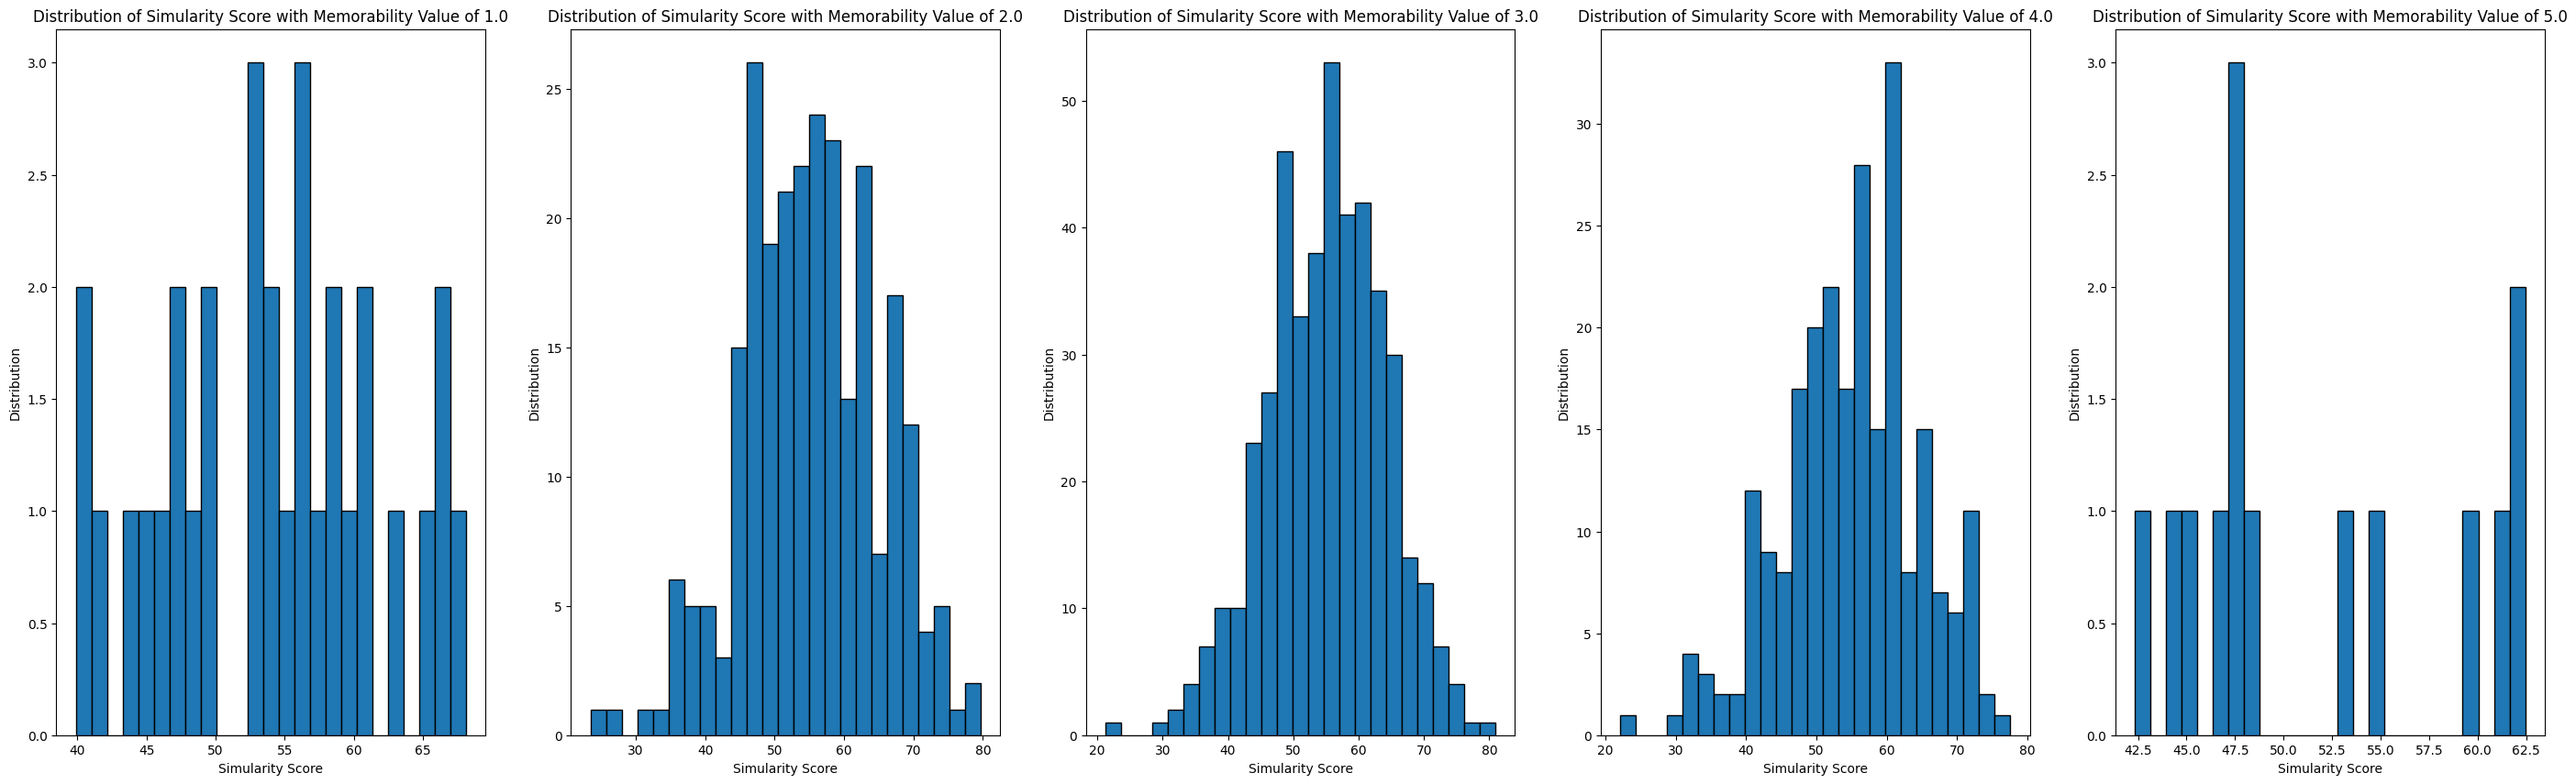

In [84]:
from matplotlib import pyplot as plt

#Define subplot parameters
fig, axes = plt.subplots(nrows=1, ncols=len(memorability_vals), figsize=(35, 10))

for ax in axes:
  ax.set_xlabel("Simularity Score")
  ax.set_ylabel("Distribution")

#Generate a new subplot based on each memorability score
index = 0
for val in memorability_vals:
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Memorable"] == val]
  treatment_vals = df2["Simularity Score"].tolist()
  axes[index].hist(treatment_vals, align='mid', edgecolor='black', bins = 25)
  axes[index].set_title(f"Distribution of Simularity Score with Memorability Value of {val}")
  index = index + 1


### Histogram of Distribution of Similarity Scores by Race

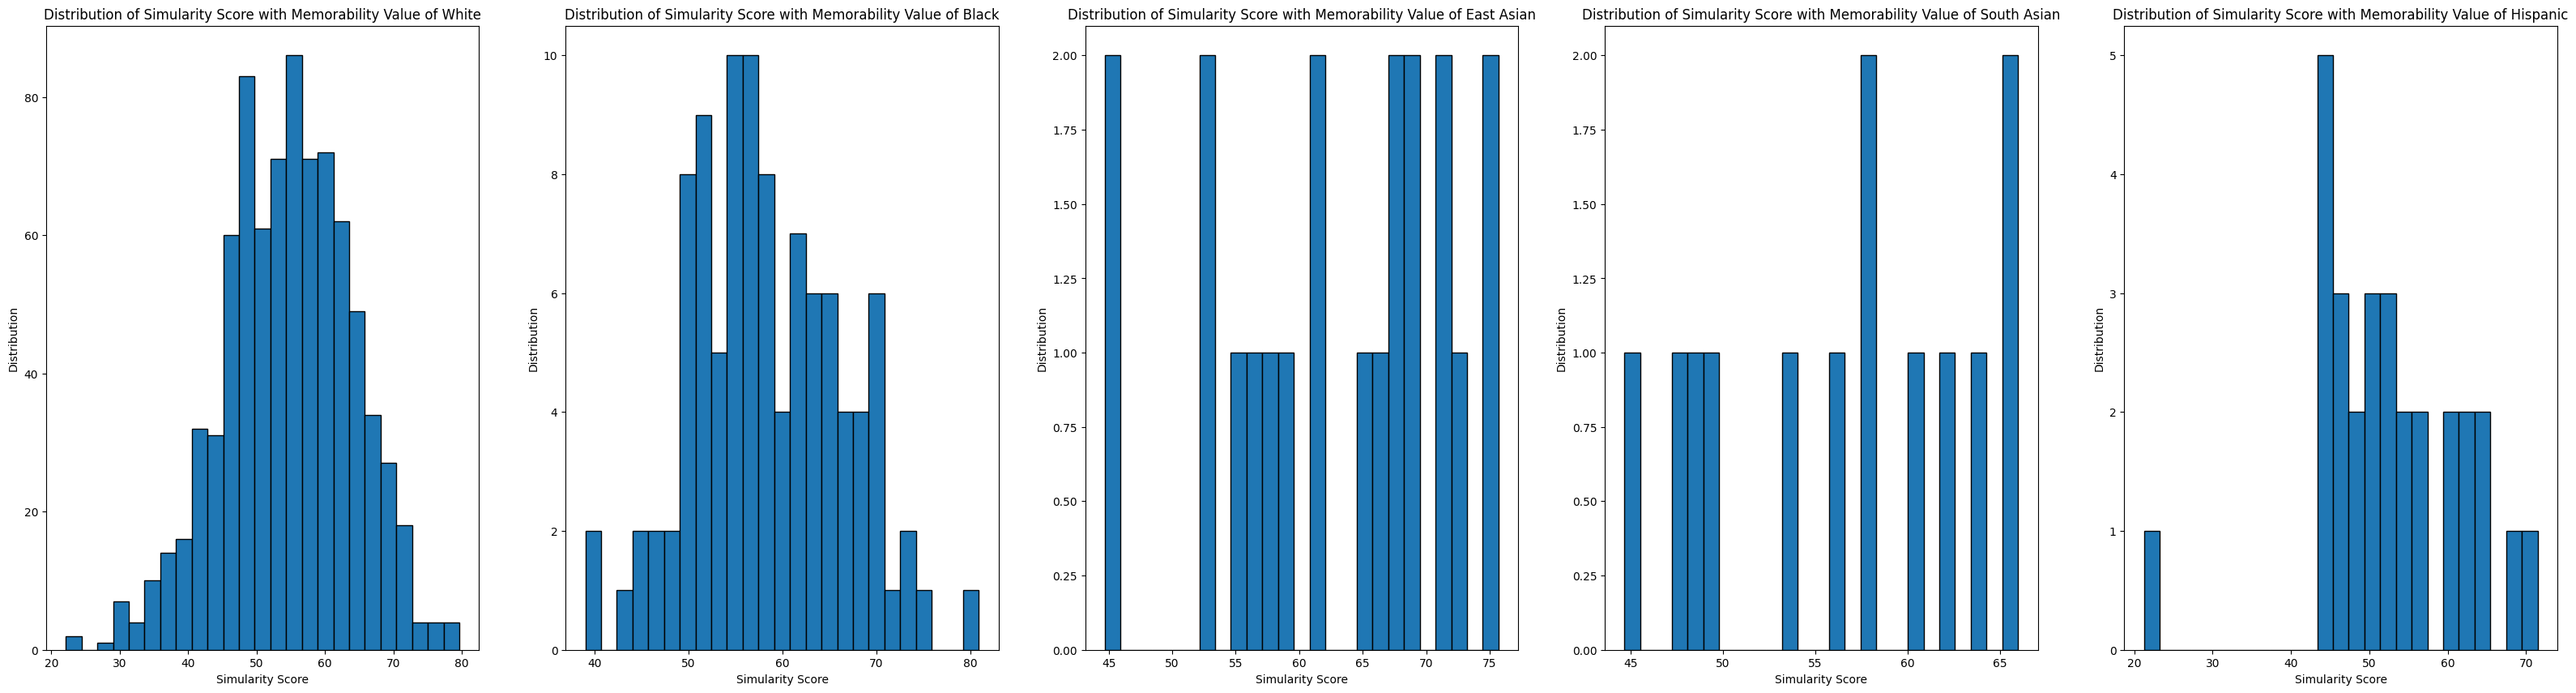

In [88]:
race_dict = {1.0: "White", 2.0: "Black", 3.0: "East Asian", 4.0: "South Asian", 5.0: "Hispanic"}

#add row to original dataframe

fig, axes = plt.subplots(nrows=1, ncols=len(race_vals), figsize=(40, 10))

for ax in axes:
  ax.set_xlabel("Simularity Score")
  ax.set_ylabel("Distribution")

#Generate a new subplot based on each race identifier
index = 0
for val in race_vals:
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Race"] == val]
  treatment_vals = df2["Simularity Score"].tolist()
  axes[index].hist(treatment_vals, align='mid', edgecolor='black', bins = 25)
  axes[index].set_title(f"Distribution of Simularity Score with Memorability Value of {race_dict[val]}")
  index = index + 1



## Pre-Data Analysis Setup

### Generating List of Similarity Scores for Each Memorability-Race Group

In [44]:

memorability_vals_new = [2.0, 3.0, 4.0]

treatment_lis = [] #Create list to hold Simularity Scores for each memorability-race treatment pair
for val in memorability_vals_new: #Iterate through each value for memorability
  df2 = images_1k_df_dropped_sorted.loc[images_1k_df_dropped_sorted["Memorable"] == val] #Subset original dataframe
  for race in race_vals: #Iterate through each race classifer
    df3 = df2.loc[df2["Race"] == race] #Subset dataframe
    treatment_vals = df3["Simularity Score"].tolist() #Convert Simularity Score column into list
    treatment_lis.append(treatment_vals) #Add list of Simularity Scores into original list

treatment_lis

[[79.66,
  50.32,
  46.8,
  49.34,
  63.57,
  69.37,
  48.98,
  60.72,
  67.52,
  52.29,
  42.1,
  46.98,
  64.6,
  51.85,
  45.86,
  57.87,
  55.16,
  57.55,
  66.21,
  74.68,
  66.84,
  55.07,
  49.37,
  45.95,
  55.13,
  57.45,
  39.11,
  56.12,
  49.74,
  51.29,
  55.2,
  36.93,
  57.64,
  38.41,
  48.08,
  62.53,
  69.85,
  35.54,
  56.68,
  35.78,
  50.58,
  50.98,
  54.86,
  37.3,
  72.03,
  45.62,
  59.3,
  56.57,
  52.16,
  63.05,
  49.47,
  59.8,
  60.44,
  59.31,
  71.99,
  63.65,
  46.78,
  40.01,
  54.61,
  47.13,
  45.28,
  45.45,
  47.93,
  41.4,
  50.96,
  61.04,
  62.61,
  45.07,
  61.84,
  68.21,
  58.32,
  55.32,
  58.71,
  75.01,
  51.83,
  63.8,
  53.53,
  74.53,
  49.44,
  68.88,
  64.49,
  43.67,
  57.96,
  43.98,
  48.49,
  54.91,
  57.21,
  55.82,
  33.24,
  53.95,
  54.46,
  46.24,
  57.62,
  55.94,
  47.48,
  53.87,
  60.19,
  53.85,
  26.76,
  59.53,
  62.12,
  62.15,
  49.69,
  36.51,
  68.32,
  46.46,
  49.3,
  63.17,
  47.8,
  68.69,
  66.44,
  63.04,
  4

In [71]:
#Only look at anova for statisitical difference in statistical scores across the 2.0, 3.0, and 4.0 memorability groups, as these groups contain data on every race

race_dict = {1.0: "W", 2.0: "B", 3.0: "EA", 4.0: "SA", 5.0: "H"} #Dictionary for race identifiers
df_treatments = pd.DataFrame(treatment_lis).T #Create dataframe based on our nested list of Simularity Scores

df_treatments.columns = [f"{int(memorability)}{race_dict[race]}" for memorability in memorability_vals_new for race in race_vals] #Create columns corresponding to each memorability-race treatment pair

df_treatments.columns



Index(['2W', '2B', '2EA', '2SA', '2H', '3W', '3B', '3EA', '3SA', '3H', '4W',
       '4B', '4EA', '4SA', '4H'],
      dtype='object')

### Preprocessing Data for ANOVA Analysis in R

In [72]:
#Melt dataframe for ANOVA analysis

df_treatments_melt = pd.melt(df_treatments.reset_index(), id_vars=['index'], value_vars= df_treatments.columns.tolist())
df_treatments_melt.columns = ['index', 'treatment', 'value']



sum_sq     df         F    PR(>F)
C(treatment)   2830.633862   14.0  2.357115  0.003251
Residual      79516.027984  927.0       NaN       NaN

#### Converting dataframe into textfile

In [89]:
with open('/content/drive/MyDrive/Data Ethics Final Project Drive/output.txt', 'w') as f:
    f.write(df_treatments_melt.to_string(index=False))